In [25]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from cnn import CNN
from im_dataset import get_loaders_and_datasets, crop_and_resize
import tqdm
import pathlib
import PIL

In [36]:
labels = ["deadlift", "hammer_curl", "tricep_pushdown", "squat", "tricep_dips", "lat_pulldown", "push_up", "barbell_biceps_curl",
          "pec_fly", "incline_bench_press", "leg_extension", "shoulder_press", "t_bar_row", "decline_bench_press", "bench_press", "pull_up",
          "plank", "lateral_raise", "leg_raise", "hip_thrust", "RDLs", "russian_twists"]

In [3]:
out_dir = pathlib.Path("exercise_ml/exp").resolve()
out_dir.mkdir(parents=True, exist_ok=True)

In [2]:
model = CNN()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
n_epochs = 10
val_steps = 1000
train_losses, val_losses = [], []
val_accs = []
val_loss, val_acc = np.nan, np.nan
min_val_loss = float("inf")
step = 0

In [5]:
tr_loader, va_loader, te_loader, tr_dataset, va_dataset, te_dataset = get_loaders_and_datasets(batch_size)


In [13]:
for epoch in range(n_epochs):
    pbar = tqdm.tqdm(tr_loader, desc=f"Epoch {epoch}")
    
    for i, (X, y) in enumerate(pbar):
        model.train()
        optimizer.zero_grad()
        X = X.float()
        y = y.long()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_losses.append(float(loss))
        loss.backward()
        optimizer.step()
        pbar.set_postfix(
            loss=float(loss), val_loss=val_loss, val_acc=val_acc, refresh=False
        )
        step += 1

        if step % val_steps == 0:
            val_loss = 0
            count_correct = 0
            total_samples = 0  # Track total samples for averaging

            for a, (ims, labels) in enumerate(va_loader):
                model.eval()
                ims = ims.float()
                labels = labels.long()
                prediction = model(ims)
                loss = loss_fn(prediction, labels)
                val_loss += len(ims) * float(loss)  # Accumulate weighted loss
                total_samples += len(ims)  # Accumulate total samples
                count_correct += torch.count_nonzero(prediction.argmax(1) == labels)

            val_loss = val_loss / total_samples  # Compute average validation loss
            val_losses.append(val_loss)

            np.save(out_dir / "val_losses.npy", val_losses)

            val_acc = float(count_correct / len(va_dataset))
            val_accs.append(val_acc)

            pbar.set_postfix(
                loss=float(loss), val_loss=val_loss, val_acc=val_acc
            )

            if val_loss < min_val_loss:
                torch.save(model.state_dict(), out_dir / f"best_model.pt")
                min_val_loss = val_loss
    
    w = 100
    train_losses_ma = np.convolve(train_losses, np.ones(w), "valid") / w


Epoch 9: 100%|██████████| 259/259 [19:53<00:00,  4.61s/it, loss=0.043, val_acc=0.528, val_loss=6.7]     


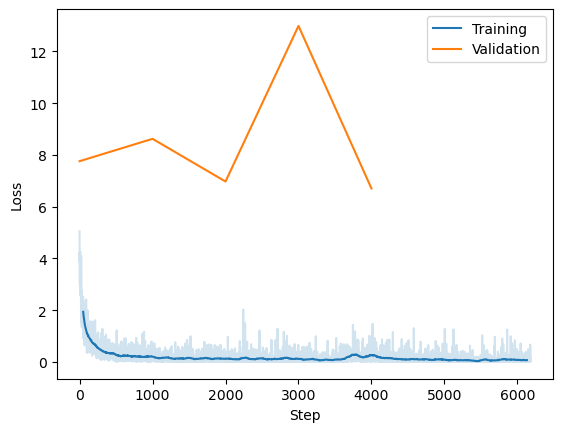

In [14]:
plt.plot(np.arange(len(train_losses)), train_losses, color="C0", alpha=0.2)
plt.plot(
     np.arange(len(train_losses_ma)) + w / 2, train_losses_ma,
        label="Training", color="C0"
)
plt.plot(
    np.arange(len(val_losses)) * val_steps, val_losses,
    label="Validation", color="C1"
)

plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.savefig("losses.png")
plt.show()

In [15]:
# Load the best model back
model.load_state_dict(
    torch.load(out_dir / "best_model.pt", weights_only=True)
)

<All keys matched successfully>

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Test loop
test_loss = 0
count_correct = 0
pbar = tqdm.tqdm(te_loader, desc="Test")
for i, (ims, labels) in enumerate(pbar):
    # Move the data to GPU
    ims = ims.float()
    labels = labels.long()
    ims = ims.to(device)
    labels = labels.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Pass the inputs through the neural network
    prediction = model(ims)

    # Compute the loss
    loss = loss_fn(prediction, labels)

    # Accumulate the loss
    test_loss += len(ims) * float(loss)

    # Accumulate the counter for correct predictions
    count_correct += torch.count_nonzero(prediction.argmax(1) == labels)

# Compute the average test loss
test_loss = test_loss / len(te_dataset)
print(f"Test loss: {test_loss}")

# Compute the average test accuracy
test_acc = count_correct / len(te_dataset)
print(f"Test accuracy: {test_acc}")

Test:   0%|          | 0/90 [00:00<?, ?it/s]

Test: 100%|██████████| 90/90 [00:19<00:00,  4.60it/s]

Test loss: 6.635485654535995
Test accuracy: 0.5314685106277466


In [ ]:
bench = image.imread("bench.jpg")
bench = crop_and_resize(bench, 64, 64)
bench = torch.tensor(bench)
bench = bench.float()
bench = bench.permute(2, 0, 1)  # Change to (C, H, W)

torch.Size([3, 64, 64])

In [ ]:
# Compute the logits, i.e., the raw output of the model
logits = model(torch.unsqueeze(bench, 0))

# Apply Softmax to convert the logits into probability-like values
pred = F.softmax(logits, dim=1).detach().cpu().numpy()

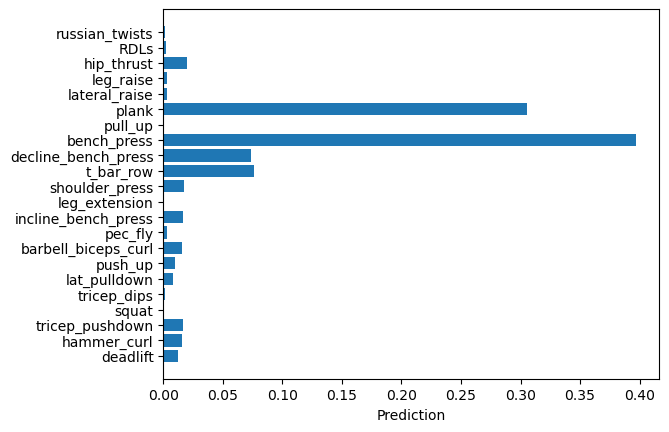

In [38]:
plt.barh(np.arange(22), pred[0])
plt.yticks(np.arange(22), labels)
plt.xlabel("Prediction")
plt.show()

In [39]:
squat = image.imread("squat.jpg")
squat = crop_and_resize(squat, 64, 64)
squat = torch.tensor(squat)
squat = squat.float()
squat = squat.permute(2, 0, 1)

In [40]:
logits = model(torch.unsqueeze(squat, 0))
preds = F.softmax(logits, dim=1).detach().cpu().numpy()

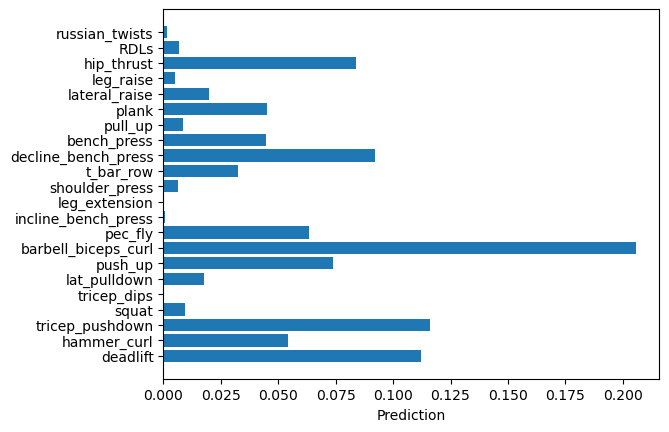

In [42]:
plt.barh(np.arange(22), preds[0])
plt.yticks(np.arange(22), labels)
plt.xlabel("Prediction")
plt.show()